# How to Develop a Weighted Average Ensemble for Deep Learning Neural Networks
https://machinelearningmastery.com/weighted-average-ensemble-for-deep-learning-neural-networks/

# Tutorial Overview

# Weighted Average Ensemble

# Multi-Class Classification Problem

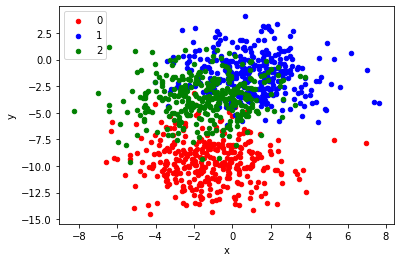

In [1]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

# Multilayer Perceptron Model

(100, 2) (1000, 2)
Train: 0.880, Test: 0.813


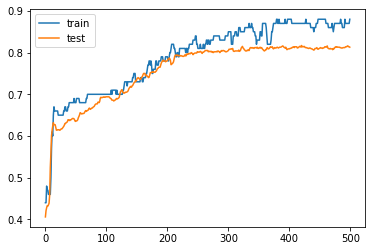

In [2]:

# develop an mlp for blobs dataset
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variable
y = to_categorical(y)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# learning curves of model accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

# Now that we have identified that the model is a good candidate for developing an ensemble, we can next look at developing a simple model averaging ensemble.

# Model Averaging Ensemble

(100, 2) (1000, 2)
> 1: single=0.805, ensemble=0.805
> 2: single=0.806, ensemble=0.805
> 3: single=0.808, ensemble=0.803
> 4: single=0.816, ensemble=0.807
> 5: single=0.810, ensemble=0.807
> 6: single=0.804, ensemble=0.809
> 7: single=0.805, ensemble=0.811
> 8: single=0.804, ensemble=0.810
> 9: single=0.813, ensemble=0.812
> 10: single=0.808, ensemble=0.811
Accuracy 0.808 (0.004)


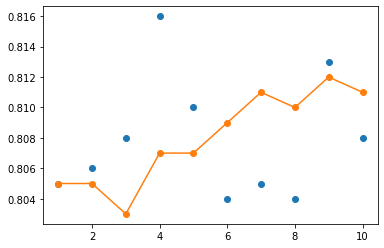

In [3]:

# model averaging ensemble for the blobs dataset
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
import numpy
from numpy import array
from numpy import argmax
 
# fit model on dataset
def fit_model(trainX, trainy):
	trainy_enc = to_categorical(trainy)
	# define model
	model = Sequential()
	model.add(Dense(25, input_dim=2, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy_enc, epochs=500, verbose=0)
	return model
 
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = array(yhats)
	#print(yhats)    
	# sum across ensemble members
	summed = numpy.sum(yhats, axis=0)
	#print(summed)    
	# argmax across classes
	result = argmax(summed, axis=1)
	#print(result)      
	return result
 
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	yhat = ensemble_predictions(subset, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)
 
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# fit all models
n_members = 10
members = [fit_model(trainX, trainy) for _ in range(n_members)]
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
	# evaluate model with i members
	ensemble_score = evaluate_n_members(members, i, testX, testy)
	# evaluate the i'th model standalone
	testy_enc = to_categorical(testy)
	_, single_score = members[i-1].evaluate(testX, testy_enc, verbose=0)
	# summarize this step
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)
# summarize average accuracy of a single final model
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

# Grid Search Weighted Average Ensemble

In [ ]:

# grid search for coefficients in a weighted average ensemble for the blobs problem
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax
from numpy import tensordot
from numpy.linalg import norm
from itertools import product
 
# fit model on dataset
def fit_model(trainX, trainy):
	trainy_enc = to_categorical(trainy)
	# define model
	model = Sequential()
	model.add(Dense(25, input_dim=2, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy_enc, epochs=500, verbose=0)
	return model
 
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, weights, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = array(yhats)
	# weighted sum across ensemble members
	summed = tensordot(yhats, weights, axes=((0),(0)))
	# argmax across classes
	result = argmax(summed, axis=1)
	return result
 
# evaluate a specific number of members in an ensemble
def evaluate_ensemble(members, weights, testX, testy):
	# make prediction
	yhat = ensemble_predictions(members, weights, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)
 
# normalize a vector to have unit norm
def normalize(weights):
	# calculate l1 vector norm
	result = norm(weights, 1)
	# check for a vector of all zeros
	if result == 0.0:
		return weights
	# return normalized vector (unit norm)
	return weights / result
 
# grid search weights
def grid_search(members, testX, testy):
	# define weights to consider
	w = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	best_score, best_weights = 0.0, None
	# iterate all possible combinations (cartesian product)
	for weights in product(w, repeat=len(members)):
		# skip if all weights are equal
		if len(set(weights)) == 1:
			continue
		# hack, normalize weight vector
		weights = normalize(weights)
		# evaluate weights
		score = evaluate_ensemble(members, weights, testX, testy)
		if score > best_score:
			best_score, best_weights = score, weights
			print('>%s %.3f' % (best_weights, best_score))
	return list(best_weights)
 
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# fit all models
n_members = 5
members = [fit_model(trainX, trainy) for _ in range(n_members)]
# evaluate each single model on the test set
testy_enc = to_categorical(testy)
for i in range(n_members):
	_, test_acc = members[i].evaluate(testX, testy_enc, verbose=0)
	print('Model %d: %.3f' % (i+1, test_acc))
# evaluate averaging ensemble (equal weights)
weights = [1.0/n_members for _ in range(n_members)]
score = evaluate_ensemble(members, weights, testX, testy)
print('Equal Weights Score: %.3f' % score)
# grid search weights
weights = grid_search(members, testX, testy)
score = evaluate_ensemble(members, weights, testX, testy)
print('Grid Search Weights: %s, Score: %.3f' % (weights, score))

(100, 2) (1000, 2)
Model 1: 0.813
Model 2: 0.813
Model 3: 0.805
Model 4: 0.823
Model 5: 0.809
Equal Weights Score: 0.816
>[0. 0. 0. 0. 1.] 0.809
>[0. 0. 0. 1. 0.] 0.823
>[0.         0.         0.         0.88888889 0.11111111] 0.824


# Weighted Average MLP Ensemble

In [ ]:

An alternative to searching for weight values is to use a directed optimization process.

Optimization is a search process, but instead of sampling the space of possible solutions randomly or exhaustively, the search process uses any available information to make the next step in the search, such as toward a set of weights that has lower error.

The SciPy library offers many excellent optimization algorithms, including local and global search methods.

SciPy provides an implementation of the Differential Evolution method. This is one of the few stochastic global search algorithms that “just works” for function optimization with continuous inputs, and it works well.

The differential_evolution() SciPy function requires that function is specified to evaluate a set of weights and return a score to be minimized. We can minimize the classification error (1 – accuracy).

As with the grid search, we most normalize the weight vector before we evaluate it. The loss_function() function below will be used as the evaluation function during the optimization process.

# loss function for optimization process, designed to be minimized
def loss_function(weights, members, testX, testy):
	# normalize weights
	normalized = normalize(weights)
	# calculate error rate
	return 1.0 - evaluate_ensemble(members, normalized, testX, testy)
We must also specify the bounds of the optimization process. We can define the bounds as a five-dimensional hypercube (e.g. 5 weights for the 5 ensemble members) with values between 0.0 and 1.0.

# define bounds on each weight
bound_w = [(0.0, 1.0) for _ in range(n_members)]
Our loss function requires three parameters in addition to the weights, which we will provide as a tuple to then be passed along to the call to the loss_function() each time a set of weights is evaluated.

# arguments to the loss function
search_arg = (members, testX, testy)
We can now call our optimization process.

We will limit the total number of iterations of the algorithms to 1,000, and use a smaller than default tolerance to detect if the search process has converged.

# global optimization of ensemble weights
result = differential_evolution(loss_function, bound_w, search_arg, maxiter=1000, tol=1e-7)
The result of the call to differential_evolution() is a dictionary that contains all kinds of information about the search.

Importantly, the ‘x‘ key contains the optimal set of weights found during the search. We can retrieve the best set of weights, then report them and their performance on the test set when used in a weighted ensemble.

# get the chosen weights
weights = normalize(result['x'])
print('Optimized Weights: %s' % weights)
# evaluate chosen weights
score = evaluate_ensemble(members, weights, testX, testy)
print('Optimized Weights Score: %.3f' % score)
Tying all of this together, the complete example is listed below.

In [1]:

# global optimization to find coefficients for weighted ensemble on blobs problem
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax
from numpy import tensordot
from numpy.linalg import norm
from scipy.optimize import differential_evolution
 
# fit model on dataset
def fit_model(trainX, trainy):
	trainy_enc = to_categorical(trainy)
	# define model
	model = Sequential()
	model.add(Dense(25, input_dim=2, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy_enc, epochs=500, verbose=0)
	return model
 
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, weights, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = array(yhats)
	# weighted sum across ensemble members
	summed = tensordot(yhats, weights, axes=((0),(0)))
	# argmax across classes
	result = argmax(summed, axis=1)
	return result
 
# # evaluate a specific number of members in an ensemble
def evaluate_ensemble(members, weights, testX, testy):
	# make prediction
	yhat = ensemble_predictions(members, weights, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)
 
# normalize a vector to have unit norm
def normalize(weights):
	# calculate l1 vector norm
	result = norm(weights, 1)
	# check for a vector of all zeros
	if result == 0.0:
		return weights
	# return normalized vector (unit norm)
	return weights / result
 
# loss function for optimization process, designed to be minimized
def loss_function(weights, members, testX, testy):
	# normalize weights
	normalized = normalize(weights)
	# calculate error rate
	return 1.0 - evaluate_ensemble(members, normalized, testX, testy)
 
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# fit all models
n_members = 5
members = [fit_model(trainX, trainy) for _ in range(n_members)]
# evaluate each single model on the test set
testy_enc = to_categorical(testy)
for i in range(n_members):
	_, test_acc = members[i].evaluate(testX, testy_enc, verbose=0)
	print('Model %d: %.3f' % (i+1, test_acc))
# evaluate averaging ensemble (equal weights)
weights = [1.0/n_members for _ in range(n_members)]
score = evaluate_ensemble(members, weights, testX, testy)
print('Equal Weights Score: %.3f' % score)
# define bounds on each weight
bound_w = [(0.0, 1.0)  for _ in range(n_members)]
# arguments to the loss function
search_arg = (members, testX, testy)
# global optimization of ensemble weights
result = differential_evolution(loss_function, bound_w, search_arg, maxiter=1000, tol=1e-7)
# get the chosen weights
weights = normalize(result['x'])
print('Optimized Weights: %s' % weights)
# evaluate chosen weights
score = evaluate_ensemble(members, weights, testX, testy)
print('Optimized Weights Score: %.3f' % score)

(100, 2) (1000, 2)
Model 1: 0.807
Model 2: 0.810
Model 3: 0.800
Model 4: 0.812
Model 5: 0.814
Equal Weights Score: 0.811
Optimized Weights: [0.04234555 0.15180768 0.01137936 0.2652593  0.52920811]
Optimized Weights Score: 0.817


https://machinelearningmastery.com/weighted-average-ensemble-for-deep-learning-neural-networks/